<a href="https://colab.research.google.com/github/manishiitg/ML_Experiments/blob/master/autoencoder/CVAE_Experiment_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE Conditional Autoencoder

In [1]:
import torch
import torch.nn as nn
import torchvision  
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader


import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
import PIL.Image as Image


transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))
    ])

batch_size = 128
mnist_data = torchvision.datasets.MNIST("data", train=True,transform=transform, download=True)
dataset_len = len(mnist_data)
data_loader = DataLoader(mnist_data,batch_size=batch_size)


0it [00:00, ?it/s]

9920512it [00:01, 8605762.16it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 141602.35it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2311854.19it/s]                            
  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 53581.35it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


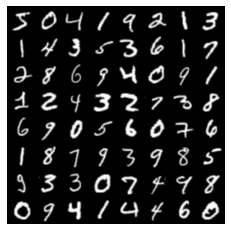

In [3]:
def show(img,renorm=False,nrow=8,interpolation='bicubic'):
  if renorm:
    img = img/2 + 0.5
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation=interpolation)
  plt.axis('off')
  plt.show()

batch, _ = next(iter(data_loader))
show(batch[0:64], renorm = True, nrow=8)

Previewing the data 

In [0]:
class VAE(nn.Module):
    def __init__(self, nc, ndf, ngf, z_dim=50, c_dims = 10):
        super(VAE, self).__init__()
        h_dim = nc * ndf * ngf
        self.nc = nc
        self.ndf = ndf
        self.ngf = ngf
        self.h_dim = h_dim
        self.encoder = nn.Sequential(
            nn.Linear(h_dim  + c_dims, 2000),
            nn.ReLU(),
            nn.Linear(2000, 500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.ReLU()
        )   
        
        self.fc1 = nn.Linear(100, z_dim)
        self.fc2 = nn.Linear(100, z_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim  + c_dims, 100),
            nn.ReLU(),
            nn.Linear(100, 500),
            nn.ReLU(),
            nn.Linear(500, 2000),
            nn.ReLU(),
            nn.Linear(2000, h_dim),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_().to(device)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x, c):
        # print("encoder input shape" , x.shape)
        # print("conditional shape", c.shape)
        x = torch.cat([x, c ], 1)
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z,c ):
        z = torch.cat([z, c ], 1)
        z = self.decoder(z)
        return z

    def forward(self, x, c):
        
        # print(x.shape, "input shape")
        x = x.view(-1, self.nc * self.ndf * self.ngf)
        # print("reshape", x.shape)
        z, mu, logvar = self.encode(x,c)
        # print("resampleing" , z.shape)
        z = self.decode(z, c)
        # print(z.shape, "output shape")
        z = z.view(-1, self.nc, self.ndf , self.ngf )
        return z, mu, logvar


conditional_dims = 10

batch, _ = next(iter(data_loader))
img = batch[1]

channels = img.size(0)
w, h = img.size(1) , img.size(2) 

nc = channels
ndf = w
ngf = h

latent_dim = 20

model = VAE(nc=nc, ngf=ngf, ndf=ndf,c_dims=conditional_dims, z_dim = latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=.0005)

def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [0]:
def get_one_hot(batch_size, label):
  label.unsqueeze_(-1)
  one_hot = torch.FloatTensor(len(label), conditional_dims).zero_()
  one_hot.scatter_(1, label,1)
  one_hot = one_hot.to(device)
  return one_hot

In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    count_data = 0
    batch_count_data = 0
    for batch_idx, (data,label) in enumerate(data_loader):
               
        one_hot = get_one_hot(len(label), label)
        images = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(images, one_hot)
        loss = loss_fn(recon_batch, images, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        count_data += len(data)
        batch_count_data += len(data)
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), dataset_len,
                100. * batch_idx / len(data_loader), loss.item() / batch_count_data))
            batch_count_data = 0
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / count_data))

    return train_loss / count_data


# train(1)


Setting up the model

In [7]:
for i in range(50):
  train(i)

epoch = 50
train_loss = 0
test_loss = 0
torch.save(model.state_dict(), './cvae/models/Epoch_{}_Train_loss_{:.4f}_Test_loss_{:.4f}.pth'.format(epoch, train_loss, test_loss))

Train Epoch: 0 [0/60000 (0%)]	Loss: 544.247803
Train Epoch: 0 [1280/60000 (2%)]	Loss: -875.883789
Train Epoch: 0 [2560/60000 (4%)]	Loss: -2809.138086
Train Epoch: 0 [3840/60000 (6%)]	Loss: -3866.390625
Train Epoch: 0 [5120/60000 (9%)]	Loss: -3609.001953
Train Epoch: 0 [6400/60000 (11%)]	Loss: -2916.343359
Train Epoch: 0 [7680/60000 (13%)]	Loss: -3554.987891
Train Epoch: 0 [8960/60000 (15%)]	Loss: -3438.623047
Train Epoch: 0 [10240/60000 (17%)]	Loss: -3011.305859
Train Epoch: 0 [11520/60000 (19%)]	Loss: -3026.544922
Train Epoch: 0 [12800/60000 (21%)]	Loss: -3340.040625
Train Epoch: 0 [14080/60000 (23%)]	Loss: -2908.716992
Train Epoch: 0 [15360/60000 (26%)]	Loss: -3680.950781
Train Epoch: 0 [16640/60000 (28%)]	Loss: -3437.018750
Train Epoch: 0 [17920/60000 (30%)]	Loss: -3473.913672
Train Epoch: 0 [19200/60000 (32%)]	Loss: -3108.372656
Train Epoch: 0 [20480/60000 (34%)]	Loss: -3182.807227
Train Epoch: 0 [21760/60000 (36%)]	Loss: -2797.205273
Train Epoch: 0 [23040/60000 (38%)]	Loss: -2545.

In [12]:
from pathlib import Path
import os

!mkdir "./cvae"
!mkdir "./cvae/models"

def load_last_model():
    models = Path('./cvae/models').rglob('*.pth')
    
    model_ids = [(int((f.as_posix()).split('_')[1]), f.as_posix()) for f in models]
    start_epoch, last_cp = max(model_ids, key=lambda item:item[0])
    print('Last checkpoint: ', last_cp)
    model.load_state_dict(torch.load(last_cp))
    return start_epoch, last_cp

epochs = 50
def resume_training():
    start_epoch, _ = load_last_model()

    for epoch in range(start_epoch + 1, start_epoch + epochs + 1):
        train_loss = train(epoch)
        # test_loss = test(epoch)
        test_loss = 0
        models = Path('./cvae/models').rglob('*.pth')
        [os.remove(f.as_posix()) for f in models]
        torch.save(model.state_dict(), './cvae/models/cvae-Epoch_{}_Train_loss_{:.4f}_Test_loss_{:.4f}.pth'.format(epoch, train_loss, test_loss))
        # !cp -rf "./vae-dfc" "drive/My Drive/Colab Notebooks/"

resume_training()

# load_last_model()


mkdir: cannot create directory ‘./cvae’: File exists
mkdir: cannot create directory ‘./cvae/models’: File exists
Last checkpoint:  cvae/models/Epoch_50_Train_loss_0.0000_Test_loss_0.0000.pth
Train Epoch: 51 [0/60000 (0%)]	Loss: -19522.679688
Train Epoch: 51 [1280/60000 (2%)]	Loss: -2130.897070
Train Epoch: 51 [2560/60000 (4%)]	Loss: -1924.140625
Train Epoch: 51 [3840/60000 (6%)]	Loss: -1955.655078
Train Epoch: 51 [5120/60000 (9%)]	Loss: -1956.199805
Train Epoch: 51 [6400/60000 (11%)]	Loss: -1927.273828
Train Epoch: 51 [7680/60000 (13%)]	Loss: -1957.962695
Train Epoch: 51 [8960/60000 (15%)]	Loss: -1969.151172
Train Epoch: 51 [10240/60000 (17%)]	Loss: -2184.655469
Train Epoch: 51 [11520/60000 (19%)]	Loss: -1948.375391
Train Epoch: 51 [12800/60000 (21%)]	Loss: -1986.569336
Train Epoch: 51 [14080/60000 (23%)]	Loss: -2133.066211
Train Epoch: 51 [15360/60000 (26%)]	Loss: -1944.671484
Train Epoch: 51 [16640/60000 (28%)]	Loss: -1946.534375
Train Epoch: 51 [17920/60000 (30%)]	Loss: -1955.400195

In [0]:
# !rm -rf "./cvae/models/Epoch*"

See the model output that compare the original image with generated image

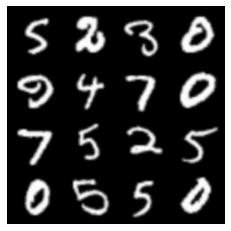

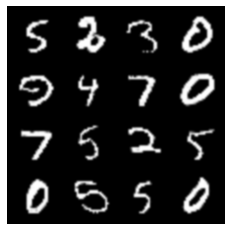

In [13]:
from torch.utils.data import RandomSampler
from torchvision.utils import save_image
import matplotlib.image as mpimg

with torch.no_grad():
  test_loader = DataLoader(mnist_data,batch_size=16, shuffle=True)
  itr = iter(test_loader)
  # next(itr)
  batch, label = next(itr)
  one_hot = get_one_hot(len(label), label)
  batch = batch.to(device)
  model.eval()
  recon_batch, _, _  = model(batch, one_hot)

  show(batch.cpu(), renorm = True, nrow=4)
  show(recon_batch.cpu(), renorm = False, nrow=4)


tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.Size([9, 784])


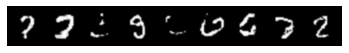

In [14]:
with torch.no_grad():
    epoch = 1
    rand1 = torch.randn(9, latent_dim).to(device)
    rand2 = torch.randn(9, latent_dim).to(device)

    z = model.reparameterize(rand1, rand2)
    labels = torch.from_numpy(np.arange(1,10))
    print(labels)
    one_hot = get_one_hot(len(labels), labels)
    sample = model.decode(z, one_hot).cpu()
    print(sample.shape)
    sample = sample.view(9, 1, 28, 28)
    
    show(sample, renorm = False, nrow=9)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!cp -rf "./cvae" "drive/My Drive/Colab Notebooks/"

In [0]:
!cp -rf "drive/My Drive/Colab Notebooks/cvae" "./cvae" 